<a href="https://colab.research.google.com/github/Donguk-Owen-Kim/DelsysAnalysis/blob/main/DelsysAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 환경 설정**

원본 CSV 첫 timestamp: 0.333
총 1개 채널 감지됨: ['ch1']


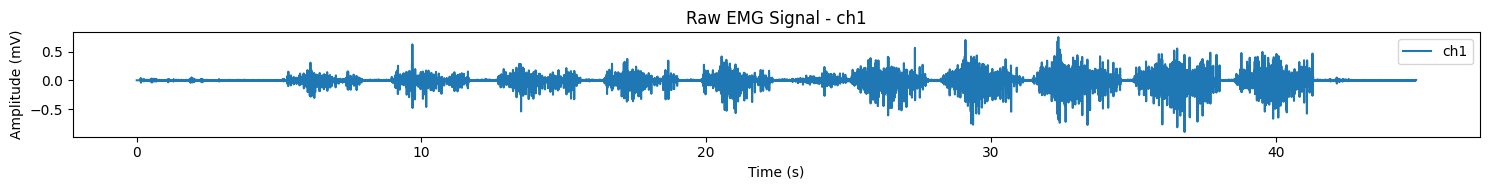

추정 EMG 샘플링 주파수: 2148.1 Hz


In [ ]:
# Colab 환경 세팅
!pip install matplotlib numpy pandas scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch

# -------------------------------
# 다중 채널 로딩 함수
# -------------------------------
def load_multi_channel_emg(filepath):
    raw_df = pd.read_csv(filepath, skiprows=1)  # 첫 행은 헤더라 무시
    raw_df = raw_df.iloc[1:]  # 실제 데이터만 사용

    channel_dict = {}
    cols = raw_df.columns
    num_channels = len(cols) // 2  # timestamp + signal 쌍 개수

    for ch in range(num_channels):
        ts_col = cols[ch * 2]
        val_col = cols[ch * 2 + 1]

        ts = raw_df[ts_col].astype(float).values
        sig = raw_df[val_col].astype(float).values

        channel_dict[f"ch{ch+1}"] = {
            "timestamp": ts,
            "signal": sig
        }

    return channel_dict

# -------------------------------
# 데이터 불러오기
# -------------------------------
emg_channels = load_multi_channel_emg("/0_data/data.csv")
pose_df = pd.read_csv("/0_data/posedata.csv")
pose_df["timestamp"] = pose_df["timestamp"].astype(float)
pose_df["angle"] = pose_df["angle"].astype(float)

print("원본 CSV 첫 timestamp:", pose_df["timestamp"].iloc[0])

# 채널 개수 확인
num_channels = len(emg_channels)
print(f"총 {len(emg_channels)}개 채널 감지됨:", list(emg_channels.keys()))

# 전체 채널 시각화 (한 Figure에 여러 개)
plt.figure(figsize=(15, num_channels * 2))

for idx, (ch_name, ch_data) in enumerate(emg_channels.items(), start=1):
    plt.subplot(num_channels, 1, idx)
    plt.plot(ch_data["timestamp"], ch_data["signal"], label=ch_name)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.title(f"Raw EMG Signal - {ch_name}")
    plt.legend()

plt.tight_layout()
plt.show()

# 원하는 채널 선택 (예: ch1)
time_emg = emg_channels["ch1"]["timestamp"]
emg_signal = emg_channels["ch1"]["signal"]

# 혹은 모든 채널 평균 사용
# all_signals = [ch["signal"] for ch in emg_channels.values()]
# emg_signal = sum(all_signals) / len(all_signals)

# 샘플링 주파수 추정
emg_fs = 1 / np.mean(np.diff(time_emg))  # Hz
print(f"추정 EMG 샘플링 주파수: {emg_fs:.1f} Hz")

time_pose = pose_df["timestamp"].values
pose_angle = pose_df["angle"].values

# **Data Filtering**

Baseline noise 제거 → DC offset과 저주파 드리프트 억제

고주파 잡음 제거 → 450Hz 이상 노이즈 감소

전력선(50/60Hz) 노이즈 제거 필요하면 추가 notch filter

RMS가 더 깨끗한 envelope 형태로 나옴


---



***Data Filtering 과정***

**1. DC offset 제거**


  *   EMG 센서가 완벽하게 0V를 기준으로 측정되지 않고, ±몇 mV 정도의 기준 전압이 밀려 있는 현상
  *   전체 신호의 평균값을 구하고, 그 값을 빼서 평균이 0이 되도록 정렬

**2. Band-pass Filtering (20~450Hz)**



*   저주파/고주파 노이즈 제거
*   `scipy.signal.butter + filtfil`t 로 위상 왜곡 없이 필터링 → 외부 환경 노이즈 제거

**3. Full-wave Rectification**



*   근육 활성 강도를 보기 위해 진폭의 크기만을 비교함
*   모든 음수 값을 양수로 변환(`abs`)


---

In [ ]:
from scipy.signal import butter, filtfilt

# Bandpass 필터 함수
def bandpass_filter(signal, lowcut=20.0, highcut=450.0, fs=emg_fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, signal)
    return filtered

# EMG 전처리
# 1) DC offset 제거
emg_signal_detrend = emg_signal - np.mean(emg_signal)

# 2) Band-pass filtering (20~450Hz)
emg_signal_filtered = bandpass_filter(emg_signal_detrend)

# 3) Full-wave rectification
emg_signal_rectified = np.abs(emg_signal_filtered)


---

---

# **2. Amplitude Analysis (RMS 분석)**



  **RMS(Root Mean Square)** → EMG 파워, 근육 활성 정도


*   EMG 신호의 평균 에너지를 나타냄 → 근육 수축 강도와 비례
*   짧은 window(예시 200ms) 단위로 RMS 계산

$$
\text{RMS} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2}
$$

---
## ***2.1. Raw Data***


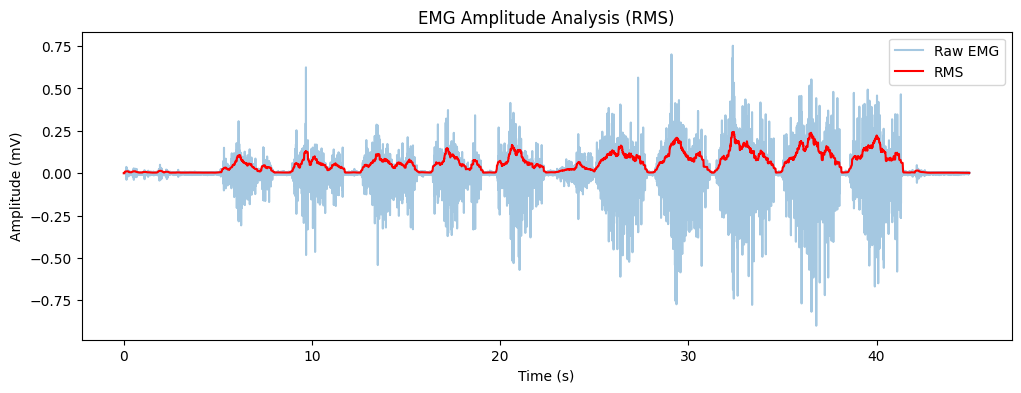

In [ ]:
# RMS 계산 함수
def compute_rms(signal, window_size=200, fs=emg_fs):
    samples = int(window_size/1000 * fs)  # 200ms → 샘플 개수
    rms_vals = np.sqrt(np.convolve(signal**2, np.ones(samples)/samples, mode='same'))
    return rms_vals

emg_rms = compute_rms(emg_signal)

plt.figure(figsize=(12,4))
plt.plot(time_emg, emg_signal, alpha=0.4, label="Raw EMG")
plt.plot(time_emg, emg_rms, label="RMS", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.title("EMG Amplitude Analysis (RMS)")
plt.legend()
plt.show()

---
## ***2.2. Filtered Data(Band-pass Filtering)***

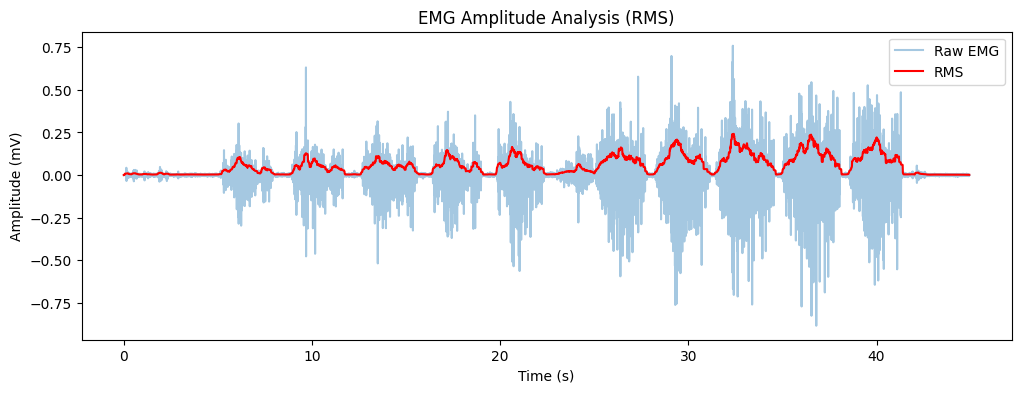

In [ ]:
emg_rms_filtered = compute_rms(emg_signal_filtered)

plt.figure(figsize=(12,4))
plt.plot(time_emg, emg_signal_filtered, alpha=0.4, label="Raw EMG")
plt.plot(time_emg, emg_rms_filtered, label="RMS", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.title("EMG Amplitude Analysis (RMS)")
plt.legend()
plt.show()

---
## ***2.3. Filtered Data(Rectified)***


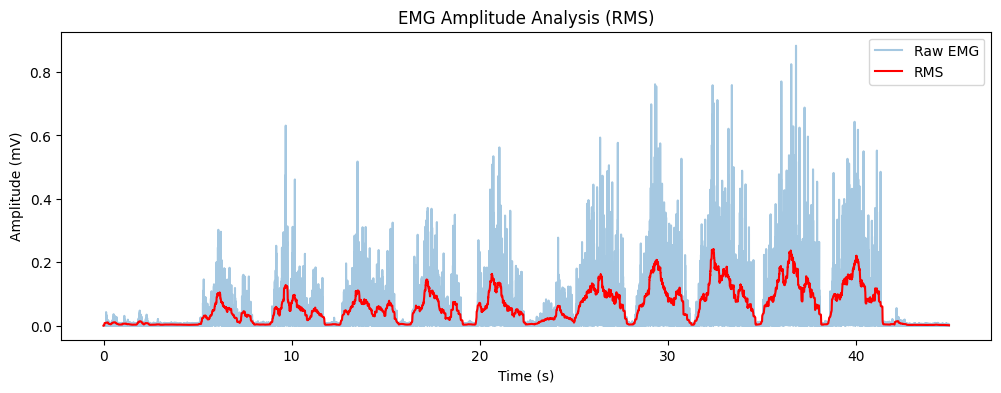

In [ ]:
emg_rms_filtered = compute_rms(emg_signal_rectified)

plt.figure(figsize=(12,4))
# RMS raw data analysis
plt.plot(time_emg, emg_signal_rectified, alpha=0.4, label="Raw EMG")
plt.plot(time_emg, emg_rms_filtered, label="RMS", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.title("EMG Amplitude Analysis (RMS)")
plt.legend()
plt.show()

---
---


# **3. Timing Analysis (Activation Intervals)** → 근육 활성 시점과 비활성 시점 구분


  **Threshold 기반 Activation**


*   RMS가 일정 임계값을 넘으면 근육 활성
*   활성화구간을 Detection



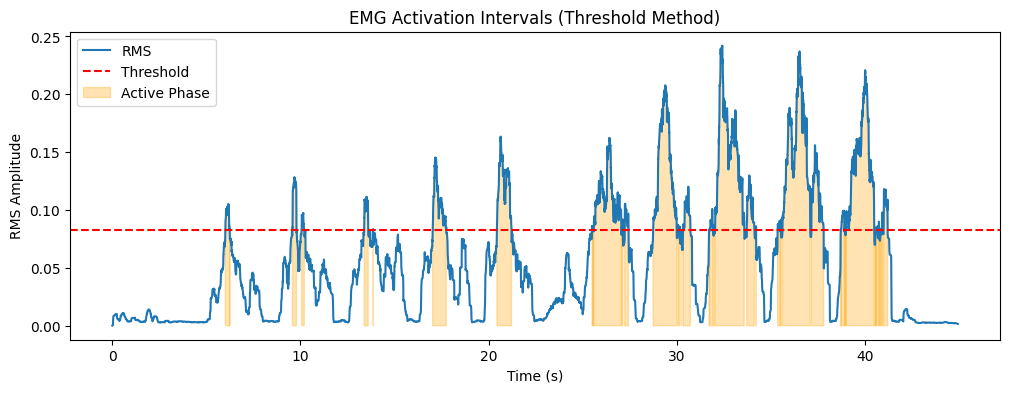

In [ ]:
threshold = np.mean(emg_rms_filtered) + 0.5*np.std(emg_rms_filtered)  # 평균+0.5*표준편차
active = emg_rms_filtered > threshold

plt.figure(figsize=(12,4))
plt.plot(time_emg, emg_rms_filtered, label="RMS")
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.fill_between(time_emg, 0, emg_rms_filtered, where=active, color='orange', alpha=0.3, label="Active Phase")
plt.title("EMG Activation Intervals (Threshold Method)")
plt.xlabel("Time (s)")
plt.ylabel("RMS Amplitude")
plt.legend()
plt.show()

# **4. Spectral Analysis (주파수 분석)**


*   Power Spectral Density (PSD): 주파수별 파워 → 근육 신호의 주파수 구성
*   Mean/Meadian Frequency → 평균/중앙 주파수, 피로(Fatigue) 평가


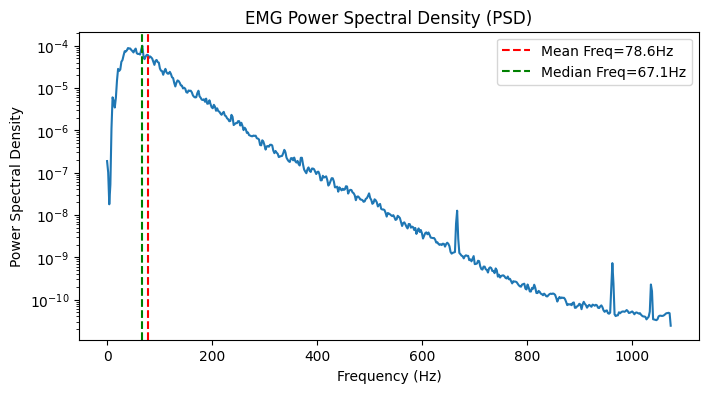

Mean Frequency: 78.58 Hz
Median Frequency: 67.13 Hz


In [ ]:
f, Pxx = welch(emg_signal, fs=emg_fs, nperseg=1024)

mean_freq = np.sum(f * Pxx) / np.sum(Pxx)  # 평균 주파수
cumsum = np.cumsum(Pxx)
median_freq = f[np.where(cumsum >= cumsum[-1]/2)[0][0]]  # 중앙 주파수

plt.figure(figsize=(8,4))
plt.semilogy(f, Pxx)
plt.axvline(mean_freq, color='red', linestyle='--', label=f"Mean Freq={mean_freq:.1f}Hz")
plt.axvline(median_freq, color='green', linestyle='--', label=f"Median Freq={median_freq:.1f}Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("EMG Power Spectral Density (PSD)")
plt.legend()
plt.show()

print(f"Mean Frequency: {mean_freq:.2f} Hz")
print(f"Median Frequency: {median_freq:.2f} Hz")

# **5. Fatigue 분석 (Median Frequency 변화)**

*   근 피로 시 median frequency가 시간에 따라 감소
*   1초 단위 segment로 median frequency 계산

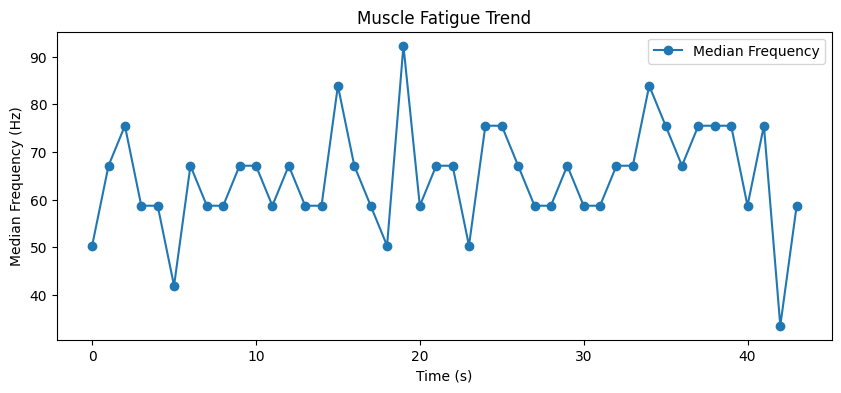

In [ ]:
segment_sec = 1.0
segment_samples = int(segment_sec * emg_fs)

med_freqs = []
segment_times = []

for start in range(0, len(emg_signal)-segment_samples, segment_samples):
    seg = emg_signal[start:start+segment_samples]
    f, Pxx = welch(seg, fs=emg_fs, nperseg=256)
    cumsum = np.cumsum(Pxx)
    mf = f[np.where(cumsum >= cumsum[-1]/2)[0][0]]
    med_freqs.append(mf)
    segment_times.append(time_emg[start])

plt.figure(figsize=(10,4))
plt.plot(segment_times, med_freqs, '-o', label="Median Frequency")
plt.xlabel("Time (s)")
plt.ylabel("Median Frequency (Hz)")
plt.title("Muscle Fatigue Trend")
plt.legend()
plt.show()

# **6. STFT (시간-주파수 스펙트로그램: 푸리에 변환)**



*   시간에 따라 주파수 분포의 변화 확인
*   근피로가 있으면 Median Frequency가 서서히 낮아짐

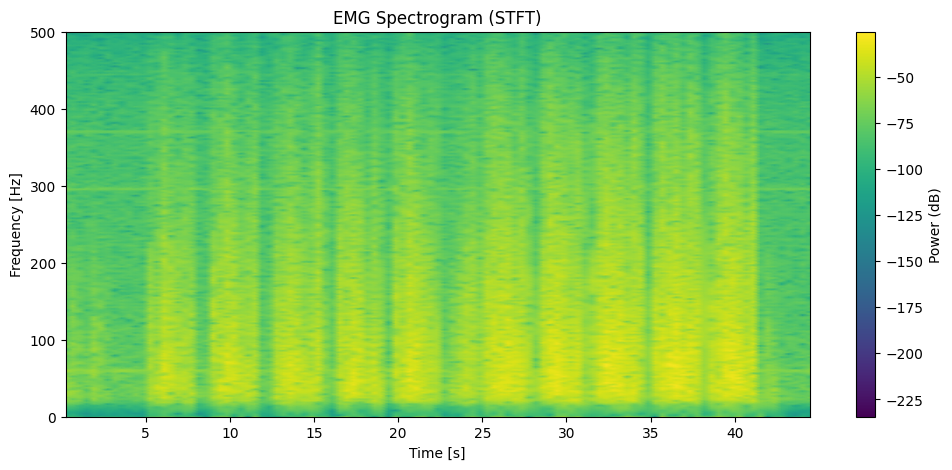

In [ ]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(emg_signal_filtered, fs=emg_fs, nperseg=1024)

plt.figure(figsize=(12,5))
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud', cmap="viridis")
plt.colorbar(label='Power (dB)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('EMG Spectrogram (STFT)')
plt.ylim(0, 500)  # EMG 유효대역
plt.show()


# **7. Pose Data Visualization**

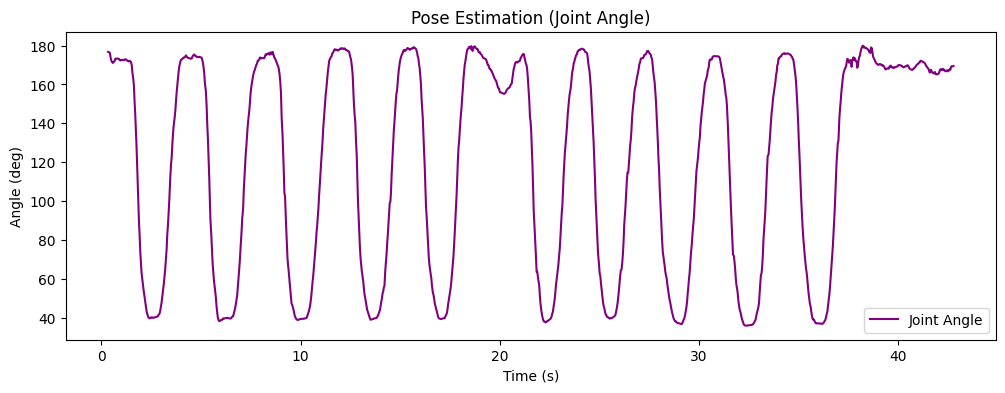

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(time_pose, pose_angle, color='purple', label="Joint Angle")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Pose Estimation (Joint Angle)")
plt.legend()
plt.show()

# **8. EMG RMS ↔ Pose Timestamp Synchronize & Overlay**

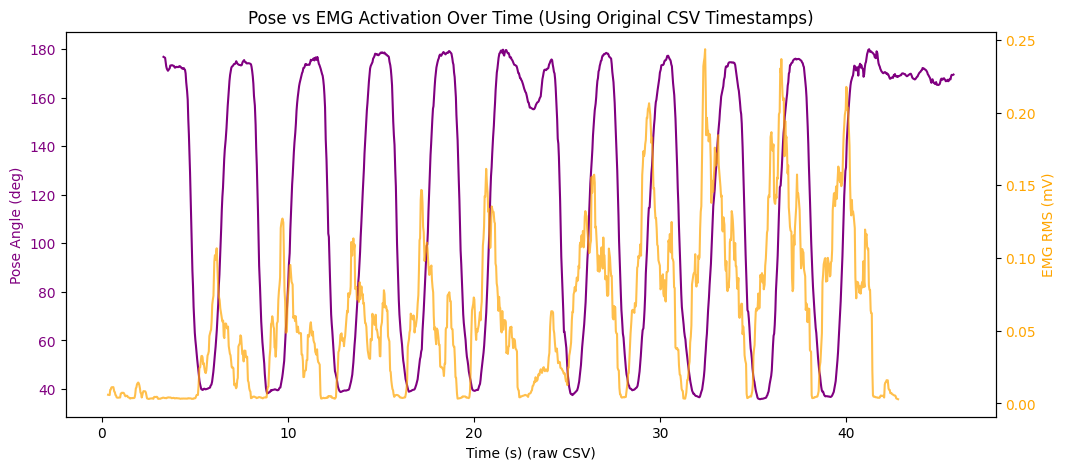

In [ ]:
# 원본 CSV 다시 읽기 (전처리 안 함)
pose_raw_df = pd.read_csv("/0_data/posedata.csv")
pose_raw_df["timestamp"] = pose_raw_df["timestamp"].astype(float)
pose_raw_df["angle"] = pose_raw_df["angle"].astype(float)


# 원본 pose timestamp로 merge
merged_df = pd.merge_asof(
    pose_raw_df,
    pd.DataFrame({"timestamp": time_emg, "emg_rms": emg_rms}),
    on="timestamp", direction="nearest"
)

# 그래프 (원본 timestamp 그대로 사용)
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(merged_df["timestamp"]+time_shift, merged_df["angle"], color="purple", label="Pose Angle")
ax1.set_xlabel("Time (s) (raw CSV)")
ax1.set_ylabel("Pose Angle (deg)", color="purple")
ax1.tick_params(axis='y', labelcolor="purple")

ax2 = ax1.twinx()
ax2.plot(merged_df["timestamp"], merged_df["emg_rms"], color="orange", alpha=0.7, label="EMG RMS")
ax2.set_ylabel("EMG RMS (mV)", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

plt.title("Pose vs EMG Activation Over Time (Using Original CSV Timestamps)")
plt.show()

